In [14]:
import tensorflow as tf
from tensorflow import keras
from keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Reshape

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

np.random.seed(10)
print (tf.__version__)

2.19.0


In [15]:
colors = pd.read_csv("colors.csv")
colors

,name,red,green,blue
0,parakeet,174,182,87
1,saddle brown,88,52,1
2,cucumber crush,222,237,215
3,pool blue,134,194,201
4,distance,98,110,130
...,...,...,...,...
14152,fire mist,251,216,197
14153,spanish leather,143,102,54
14154,aquatone,165,180,170
14155,bottle green,9,54,36


<BarContainer object of 256 artists>

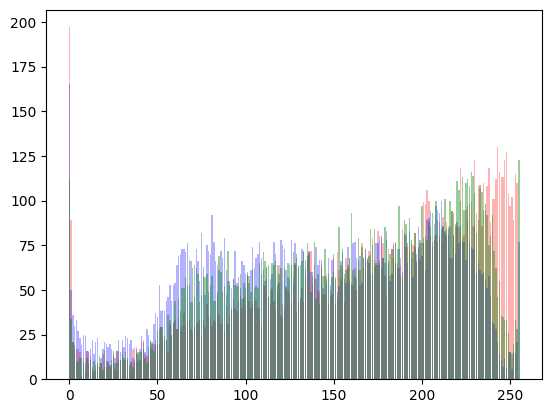

In [16]:
#This is kinda stupid, but idk I thought it was neat ok!

red = colors.groupby("red", as_index = True).agg("count")["name"]
blue = colors.groupby("blue", as_index = True).agg("count")["name"]
green = colors.groupby("green", as_index = True).agg("count")["name"]

#placeholder to make it a little easier to see
red[255] = 0
#red
#plt.hist(red, bins = 20)
plt.bar(x = red.index, height = red, color = 'red', alpha = 0.3)
plt.bar(x = blue.index, height = blue, color = 'blue', alpha = 0.3)
plt.bar(x = green.index, height = green, color = 'green', alpha = 0.4)

In [17]:
names = colors["name"]
h = names.str.len().to_numpy()
print(min(h))
print(max(h))

#shortest string of 3 and maximum string length of 30

3
30


### Tokenizer on the char level

In [18]:
#maxlen of 25 to not compromise integrity of training data
maxlen = 25
t = Tokenizer(char_level = True)
t.fit_on_texts(names)
tokenized = t.texts_to_sequences(names)
padded_names = preprocessing.sequence.pad_sequences(tokenized, maxlen = maxlen)

In [19]:
tokenized

[[15, 2, 3, 2, 21, 1, 1, 9],
 [10, 2, 13, 13, 7, 1, 4, 18, 3, 8, 20, 6],
 [11, 12, 11, 12, 17, 18, 1, 3, 4, 11, 3, 12, 10, 16],
 [15, 8, 8, 7, 4, 18, 7, 12, 1],
 [13, 5, 10, 9, 2, 6, 11, 1],
 [7, 5, 14, 16, 9, 4, 12, 3, 15, 7, 1],
 [1, 2, 10, 9, 4, 10, 5, 13, 1],
 [22, 7, 8, 3, 5, 13, 2, 4, 10, 1, 2, 10, 16, 1, 7, 7, 10],
 [15, 2, 3, 5, 10],
 [15, 8, 20, 13, 1, 3, 4, 18, 7, 12, 10, 16],
 [17, 5, 13, 13, 7, 1, 4, 18, 7, 12, 1],
 [9, 12, 3, 9, 7, 1, 4, 14, 3, 1, 1, 6],
 [3, 1, 7, 2, 27, 5, 6, 14, 4, 18, 7, 12, 1],
 [20, 2, 10, 2, 18, 5, 4, 15, 8, 20, 13, 1, 3],
 [3, 8, 10, 1, 17, 2, 3, 19, 4, 10, 15, 3, 5, 14],
 [7, 5, 14, 16, 9, 4, 17, 2, 12, 23, 1],
 [2, 5, 3, 18, 3, 12, 10, 16, 1, 13, 4, 11, 8, 15, 15, 1, 3],
 [10, 6, 8, 20, 4, 22, 7, 12, 3, 3, 19],
 [2, 12, 3, 8, 3, 2, 4, 18, 3, 8, 20, 6],
 [14, 8, 7, 13, 4, 18, 12, 22, 22],
 [2, 6, 9, 5, 25, 12, 2, 3, 5, 2, 6, 4, 18, 3, 8, 20, 6],
 [10, 8, 15, 16, 5, 10, 9, 5, 11, 2, 9, 1, 13, 4, 7, 5, 7, 2, 11],
 [10, 20, 1, 1, 9, 4, 15, 1, 2, 11, 

In [20]:
t.word_index

{'e': 1,
 'a': 2,
 'r': 3,
 ' ': 4,
 'i': 5,
 'n': 6,
 'l': 7,
 'o': 8,
 't': 9,
 's': 10,
 'c': 11,
 'u': 12,
 'd': 13,
 'g': 14,
 'p': 15,
 'h': 16,
 'm': 17,
 'b': 18,
 'y': 19,
 'w': 20,
 'k': 21,
 'f': 22,
 'v': 23,
 'z': 24,
 'q': 25,
 'j': 26,
 'x': 27}

In [21]:
from keras.utils import to_categorical

one_hot_names = to_categorical(padded_names)
one_hot_names.shape

num_classes = one_hot_names.shape[-1]
one_hot_names.shape

(14157, 25, 28)

In [22]:
def norm(val):
    return val / 255.0

normalized_values = np.column_stack([norm(colors["red"]), norm(colors["green"]), norm(colors["blue"])])
normalized_values

array([[0.68235294, 0.71372549, 0.34117647],
       [0.34509804, 0.20392157, 0.00392157],
       [0.87058824, 0.92941176, 0.84313725],
       ...,
       [0.64705882, 0.70588235, 0.66666667],
       [0.03529412, 0.21176471, 0.14117647],
       [0.6745098 , 0.43921569, 0.41960784]])

In [23]:
'''

model = Sequential([
    LSTM(256, return_sequences=True, input_shape = (maxlen, 28)),
    LSTM(128),
    Dense(128, activation = 'relu'),
    Dense(3, activation = 'sigmoid')
])

'''
#model.compile(optimizer='adam', loss = 'mse')
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(maxlen, num_classes)))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])
model.summary()

C:\Users\mtkub\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 25, 256)        │       291,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 505,859 (1.93 MB)

 Trainable params: 505,859 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(one_hot_names, normalized_values, epochs = 40, batch_size = 32, validation_split = 0.1)

Epoch 1/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - acc: 0.5750 - loss: 0.0637 - val_acc: 0.6716 - val_loss: 0.0622
Epoch 2/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - acc: 0.6714 - loss: 0.0571 - val_acc: 0.6709 - val_loss: 0.0558
Epoch 3/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - acc: 0.6756 - loss: 0.0524 - val_acc: 0.6801 - val_loss: 0.0539
Epoch 4/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - acc: 0.6641 - loss: 0.0499 - val_acc: 0.6928 - val_loss: 0.0514
Epoch 5/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - acc: 0.6810 - loss: 0.0469 - val_acc: 0.6822 - val_loss: 0.0488
Epoch 6/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - acc: 0.6704 - loss: 0.0454 - val_acc: 0.6935 - val_loss: 0.0485
Epoch 7/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - acc: 0.6688 - loss: 0.0434 - val_acc: 0.6716 - val_loss: 0.0478
Epoch 8/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - acc: 0.6744 - loss: 0.0407 - val_acc: 0.6928 - val_loss: 0.0460
Epoch 9/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 

In [25]:
model.fit(one_hot_names, normalized_values, epochs = 10, batch_size=32)

Epoch 1/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - acc: 0.8049 - loss: 0.0119
Epoch 2/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - acc: 0.8013 - loss: 0.0090
Epoch 3/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - acc: 0.8165 - loss: 0.0072
Epoch 4/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - acc: 0.8248 - loss: 0.0064
Epoch 5/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - acc: 0.8245 - loss: 0.0061
Epoch 6/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - acc: 0.8325 - loss: 0.0061
Epoch 7/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - acc: 0.8342 - loss: 0.0059
Epoch 8/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - acc: 0.8330 - loss: 0.0058
Epoch 9/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - acc: 0.8415 - loss: 0.0054
Epoch 10/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - acc: 0.8409 - loss: 0.0056


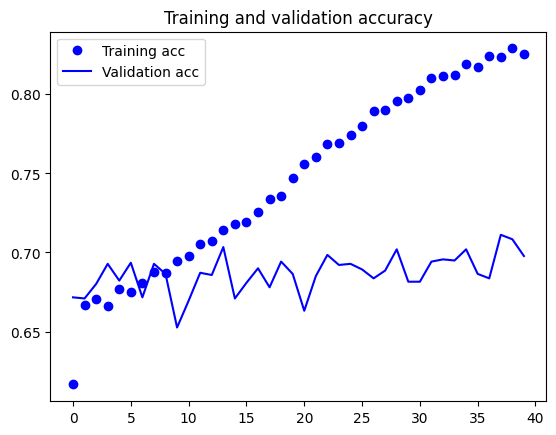

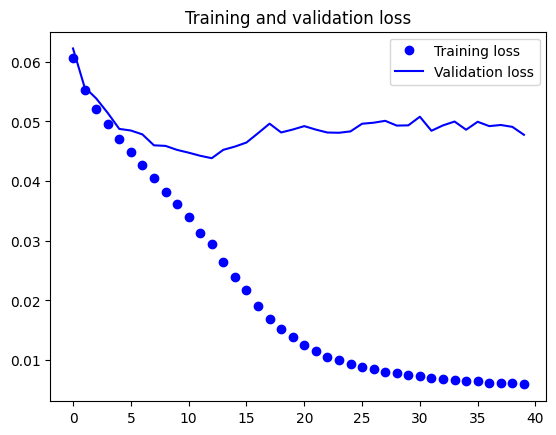

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


[[18, 7, 12, 1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted RGB value: R:6 G:36 B:217


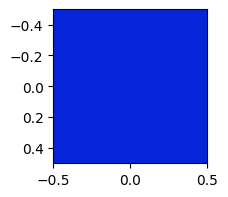

[6, 36, 217]

In [32]:
def plot_color(color):
    data = [[color]]
    plt.figure(figsize=(2,2))
    plt.imshow(color, interpolation = "nearest")
    plt.show()

def scale(num):
    return int(num * 255)

def predict_color(name):
    name = name.lower()
    tokenized = t.texts_to_sequences([name])
    print(tokenized)
    padded =  preprocessing.sequence.pad_sequences(tokenized, maxlen = maxlen)
    one_hot = to_categorical(padded, num_classes=28)

    output = model.predict(np.array(one_hot))[0]
    r,g,b = scale(output[0]), scale(output[1]), scale(output[2])
    print(f"Predicted RGB value: R:{r} G:{g} B:{b}")

    plot_color([[output]])
    return [r,g,b]

predict_color("Blue")

[[17, 5, 9, 11, 16]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted RGB value: R:170 G:177 B:172


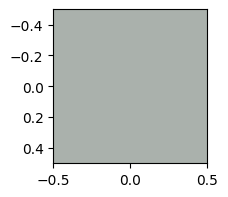

[170, 177, 172]

In [46]:
predict_color("mitch")

[[23, 1, 3, 19, 4, 23, 1, 3, 19, 4, 23, 1, 3, 19, 4, 13, 2, 3, 21, 4, 18, 7, 12, 1, 4, 2, 6, 13, 4, 10, 9, 12, 22, 22, 4, 2, 6, 13, 4, 10, 8, 17, 1, 4, 8, 9, 16, 1, 3, 4, 10, 9, 12, 22, 22]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted RGB value: R:219 G:226 B:226


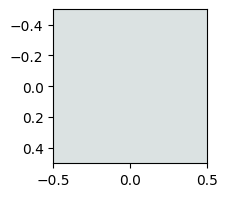

[219, 226, 226]

In [51]:
predict_color("very very very dark blue and stuff and some other stuff")